In [ ]:
import os

base_dir = "/content/CASIA2/CASIA 2 Groundtruth"
count = 0
for root, _, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith(('.jpg', '.png','.tif')):
            count += 1
            print(os.path.join(root, f))
print(f"Total images found: {count}")

/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00099_pla00099_10618_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00051_pla00051_01160_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla20021_pla20021_02389_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00091_pla00091_00613_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00052_pla00052_00586_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla20008_pla20008_01908_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00038_pla00038_00573_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00042_pla00042_01153_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00088_pla00088_01189_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00078_pla00078_00603_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00039_pla00039_00574_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_pla00075_pla00075_10621_gt.png
/content/CASIA2/CASIA 2 Groundtruth/Tp_S

In [ ]:
import os, shutil, random
from pathlib import Path

source_dir = Path("/content/CASIA2")
output_dir = Path("/content/CASIA2_Classification")

real_files = list((source_dir / "Au").glob("*.jpg")) + list((source_dir / "Au").glob("*.png"))
fake_files = list((source_dir / "Tp").glob("*.jpg")) + list((source_dir / "Tp").glob("*.png"))

random.shuffle(real_files)
random.shuffle(fake_files)

def split_data(files):
    n = len(files)
    return files[:int(0.7*n)], files[int(0.7*n):int(0.85*n)], files[int(0.85*n):]

real_train, real_val, real_test = split_data(real_files)
fake_train, fake_val, fake_test = split_data(fake_files)

for split in ["train", "val", "test"]:
    (output_dir / split / "real").mkdir(parents=True, exist_ok=True)
    (output_dir / split / "fake").mkdir(parents=True, exist_ok=True)

def copy_fast(file_list, target_dir):
    for f in file_list:
        shutil.copy2(f, target_dir / f.name)

copy_fast(real_train, output_dir / "train" / "real")
copy_fast(fake_train, output_dir / "train" / "fake")
copy_fast(real_val, output_dir / "val" / "real")
copy_fast(fake_val, output_dir / "val" / "fake")
copy_fast(real_test, output_dir / "test" / "real")
copy_fast(fake_test, output_dir / "test" / "fake")

print("✅ Local split complete (no Drive slowdowns).")


✅ Local split complete (no Drive slowdowns).


In [ ]:
!cp -r "/content/CASIA2_Classification" "/content/drive/MyDrive/"
print("✅ Final dataset saved to Google Drive.")


✅ Final dataset saved to Google Drive.


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=cf67ce85d9b5111409904717b8e2736515fe5c80995cd8339855a444da5e9f0f
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [ ]:
!pip install efficientnet_pytorch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset path
data_dir = "/content/CASIA2_Classification"

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_transform)

# Class counts for weighted loss
real_count = sum(1 for _, label in train_data.samples if label == 0)
fake_count = sum(1 for _, label in train_data.samples if label == 1)

weight_real = fake_count / (real_count + fake_count)
weight_fake = real_count / (real_count + fake_count)

class_weights = torch.tensor([weight_real, weight_fake]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Load EfficientNet-B3
model = EfficientNet.from_pretrained('efficientnet-b3')
model._fc = nn.Linear(model._fc.in_features, 2)  # 2 classes: REAL, FAKE
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 12

train_losses, val_losses = [], []

print("🚀 Training started...")

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(total_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_losses[-1]:.4f}  Val Loss: {val_losses[-1]:.4f}")

print("✅ Training Completed Successfully!")

# Save Model
torch.save(model.state_dict(), "/content/efficientnet_b3_forgerynet.pth")
print("💾 Model Saved!")


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=a320e830c8e8e85a4e6d7bfee7a6bf6ccb3465c47ffea93d5b59497056fefe32
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch
Using device: cuda
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:00<00:00, 75.3MB/s]


Loaded pretrained weights for efficientnet-b3
🚀 Training started...
Epoch [1/12]  Train Loss: 0.5872  Val Loss: 0.4570
Epoch [2/12]  Train Loss: 0.4155  Val Loss: 0.4007
Epoch [3/12]  Train Loss: 0.3238  Val Loss: 0.4596
Epoch [4/12]  Train Loss: 0.2879  Val Loss: 0.4369
Epoch [5/12]  Train Loss: 0.2332  Val Loss: 0.3439
Epoch [6/12]  Train Loss: 0.2117  Val Loss: 0.3433
Epoch [7/12]  Train Loss: 0.1921  Val Loss: 0.4134
Epoch [8/12]  Train Loss: 0.1764  Val Loss: 0.3422
Epoch [9/12]  Train Loss: 0.1711  Val Loss: 0.3827
Epoch [10/12]  Train Loss: 0.1549  Val Loss: 0.4884
Epoch [11/12]  Train Loss: 0.1862  Val Loss: 0.4279
Epoch [12/12]  Train Loss: 0.1720  Val Loss: 0.3477
✅ Training Completed Successfully!
💾 Model Saved!


In [ ]:
!cp "/content/efficientnet_b3_forgerynet.pth" "/content/drive/MyDrive/efficientnet_b3_forgerynet.pth"
print("✅ Model saved to Google Drive successfully!")


✅ Model saved to Google Drive successfully!


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

threshold = 0.65  # <-- adjust here

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:,1]  # Probability of FAKE
        preds = (probs > threshold).long().cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=["REAL","FAKE"]))
print(confusion_matrix(all_labels, all_preds))


              precision    recall  f1-score   support

        REAL       0.56      0.88      0.69       311
        FAKE       0.96      0.81      0.88      1118

    accuracy                           0.83      1429
   macro avg       0.76      0.85      0.78      1429
weighted avg       0.87      0.83      0.84      1429

[[274  37]
 [211 907]]


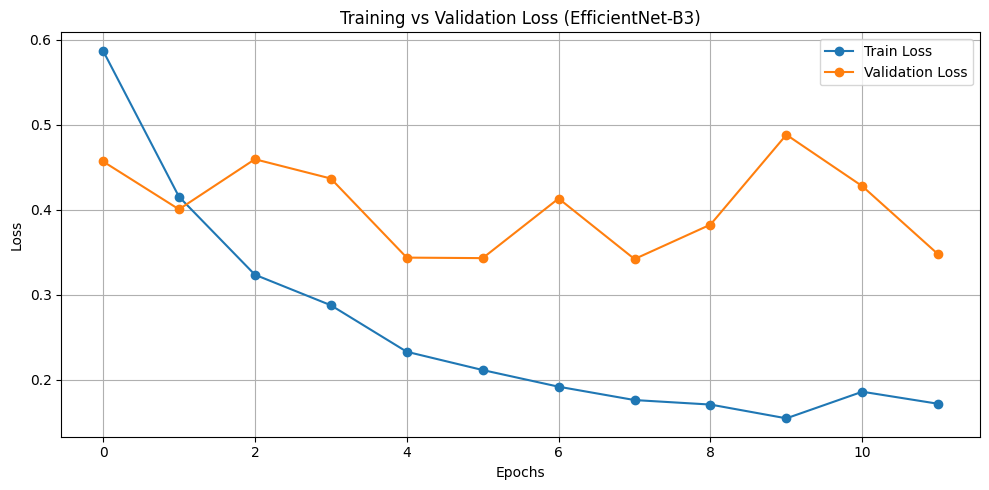

In [ ]:
import matplotlib.pyplot as plt

train_losses = [0.5872, 0.4155, 0.3238, 0.2879, 0.2332, 0.2117, 0.1921, 0.1764, 0.1711, 0.1549, 0.1862, 0.1720]
val_losses =   [0.4570, 0.4007, 0.4596, 0.4369, 0.3439, 0.3433, 0.4134, 0.3422, 0.3827, 0.4884, 0.4279, 0.3477]

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (EfficientNet-B3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Update this path to your dataset folder
dataset_path = "/content/drive/MyDrive/CASIA2_Classification"

# Same transforms you used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(dataset_path + "/train", transform=transform)
val_dataset   = datasets.ImageFolder(dataset_path + "/val", transform=transform)
test_dataset  = datasets.ImageFolder(dataset_path + "/test", transform=transform)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Dataloaders loaded successfully!")
print(train_dataset.class_to_idx)


Dataloaders loaded successfully!
{'fake': 0, 'real': 1}


In [ ]:
import torch
from tqdm import tqdm

def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Calculate accuracies
train_acc = calculate_accuracy(model, train_loader, device)
val_acc = calculate_accuracy(model, val_loader, device)
test_acc = calculate_accuracy(model, test_loader, device)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


 57%|█████▋    | 51/90 [10:27<09:38, 14.82s/it]

In [ ]:
import random, glob

fake_samples = glob.glob("/content/CASIA2_Classification/test/fake/*")
sample_fake = random.choice(fake_samples)
sample_fake


'/content/CASIA2_Classification/test/fake/Tp_D_NRN_S_O_ani10178_ani10200_12484.jpg'

In [ ]:
!pip uninstall -y grad-cam
!pip install grad-cam==1.4.6



Found existing installation: grad-cam 1.5.5
Uninstalling grad-cam-1.5.5:
  Successfully uninstalled grad-cam-1.5.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38340 sha256=fa1d67e89a9335b70db46821ad45efd54cd07a9dd870eeb790b20e298ebbeb3a
  Stored in directory: /root/.cache/pip/wheels/02/26/f1/92ac7f7699f6f0849e03e212b8b0bb8d2c3d7b2723aa474b22
Successfully built grad-cam


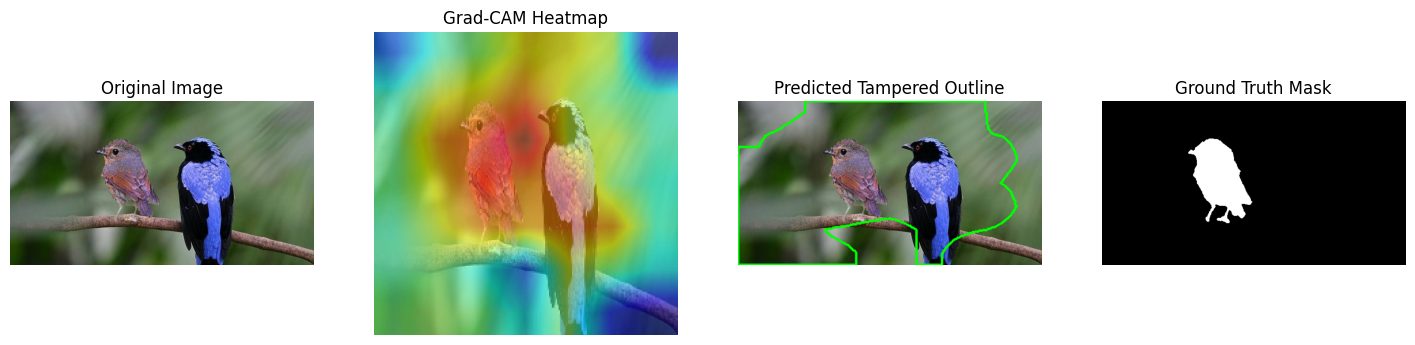

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import os

target_layer = model._blocks[-1]

fake_dir = "/content/drive/MyDrive/CASIA2_Classification/test/fake"
mask_dir = "/content/drive/MyDrive/CASIA2/CASIA 2 Groundtruth"

def visualize_with_ground_truth(image_filename):
    image_path = os.path.join(fake_dir, image_filename)

    # Derive ground truth mask filename
    mask_filename = image_filename.replace(".jpg", "_gt.png").replace(".JPG","_gt.png")
    mask_path = os.path.join(mask_dir, mask_filename)

    # Load Image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (224,224)) / 255.0
    input_tensor = torch.tensor(img_resized).permute(2,0,1).unsqueeze(0).float().to(device)

    # Grad-CAM Heatmap
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    heatmap = show_cam_on_image(img_resized, grayscale_cam, use_rgb=True)

    # Mask Prediction (Contour)
    mask_pred = (grayscale_cam > 0.45).astype(np.uint8) * 255
    mask_pred = cv2.resize(mask_pred, (img_rgb.shape[1], img_rgb.shape[0]))
    contours, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = img_rgb.copy()
    cv2.drawContours(outlined, contours, -1, (0,255,0), 3)

    # Load Ground Truth Mask
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (img_rgb.shape[1], img_rgb.shape[0]))

    # Display Panels
    plt.figure(figsize=(18,5))

    plt.subplot(1,4,1); plt.title("Original Image"); plt.imshow(img_rgb); plt.axis("off")
    plt.subplot(1,4,2); plt.title("Grad-CAM Heatmap"); plt.imshow(heatmap); plt.axis("off")
    plt.subplot(1,4,3); plt.title("Predicted Tampered Outline"); plt.imshow(outlined); plt.axis("off")
    plt.subplot(1,4,4); plt.title("Ground Truth Mask"); plt.imshow(gt, cmap="gray"); plt.axis("off")

    plt.show()

visualize_with_ground_truth("Tp_D_NRN_S_O_ani10178_ani10200_12484.jpg")


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Load EfficientNet-B3 backbone
model = EfficientNet.from_pretrained('efficientnet-b3')

# Replace final layer for 2 classes
model._fc = nn.Linear(model._fc.in_features, 2)

# Load your trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/efficientnet_b3_forgerynet.pth", map_location=device))

model = model.to(device)
model.eval()

print("✅ Model reloaded successfully.")


Using: cuda
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:01<00:00, 43.1MB/s]


Loaded pretrained weights for efficientnet-b3
✅ Model reloaded successfully.


In [ ]:
from torchvision import datasets
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/CASIA2_Classification/train")
print(train_dataset.class_to_idx)


{'fake': 0, 'real': 1}


In [ ]:
!pip install streamlit grad-cam efficientnet_pytorch


In [ ]:
!pip install pyngrok


In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("35CDa27dJ7zLBmN8260UTIv58Fj_PhXaQ1J9Uxb67XEh5uPX")


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://ambrose-metallographical-yvette.ngrok-free.dev" -> "http://localhost:8501">

In [ ]:
!streamlit run app.py --server.port 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.84.215:8501

  Stopping...
  Stopping...


In [ ]:
!pip install streamlit cloudflared -q


In [ ]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


Selecting previously unselected package cloudflared.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &


In [ ]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate


2025-11-08T12:41:00Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-08T12:41:00Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-08T12:41:05Z INF +--------------------------------------------------------------------------------------------+
2025-11-08T12:41:05Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-08T12:41:05Z INF |  https://lasting-format-greene-secretariat.trycloudfla

In [ ]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
added 22 packages in 5s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋

In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &


In [ ]:
!lt --port 8501


your url is: https://thick-colts-clap.loca.lt
^C


In [ ]:
# stop any running localtunnel or streamlit processes
!pkill -f lt || true
!pkill -f localtunnel || true
!pkill -f streamlit || true


^C
^C
^C


In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &


In [ ]:
!npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹your url is: https://tall-badgers-search.loca.lt
^C


In [ ]:
!npm uninstall -g localtunnel
!npm install -g localtunnel



⠙
removed 22 packages in 351ms
⠙⠙⠹⠸⠼
added 22 packages in 625ms
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [ ]:
!tail -n 40 /content/logs.txt





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.84.215:8501

  Stopping...


In [ ]:
!streamlit run app.py --server.port 8502 & sleep 999999





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.126.84.215:8502

  Stopping...
^C
